In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
import h5py

%matplotlib inline

In [2]:
plt.style.use('notebook')

In [3]:
f = h5py.File('../data/h3_mcat_v03.0.h5','r')

In [4]:
f.keys()

<KeysViewHDF5 ['B', 'BHB', 'DEC', 'EBV', 'GAIA_DEC', 'GAIA_G', 'GAIA_G_ERR', 'GAIA_ID', 'GAIA_RA', 'H3_ID', 'L', 'MGIANT', 'PS_G', 'PS_G_ERR', 'PS_I', 'PS_ID', 'PS_I_ERR', 'PS_R', 'PS_R_ERR', 'PS_Y', 'PS_Y_ERR', 'PS_Z', 'PS_Z_ERR', 'RA', 'RAND', 'SDSS_G', 'SDSS_G_ERR', 'SDSS_I', 'SDSS_I_ERR', 'SDSS_R', 'SDSS_R_ERR', 'SDSS_U', 'SDSS_U_ERR', 'SDSS_Z', 'SDSS_Z_ERR', 'TMASS_H', 'TMASS_H_ERR', 'TMASS_J', 'TMASS_J_ERR', 'TMASS_K', 'TMASS_K_ERR', 'WISE_W1', 'WISE_W1_ERR', 'WISE_W2', 'WISE_W2_ERR', 'brutus_bs_Av', 'brutus_bs_Mr', 'brutus_bs_Rv', 'brutus_bs_bestchi2', 'brutus_bs_dist', 'brutus_bs_feh', 'brutus_bs_good', 'brutus_bs_lerr_Av', 'brutus_bs_lerr_Mr', 'brutus_bs_lerr_Rv', 'brutus_bs_lerr_dist', 'brutus_bs_lerr_feh', 'brutus_bs_nbands', 'brutus_bs_std_Av', 'brutus_bs_std_Mr', 'brutus_bs_std_Rv', 'brutus_bs_std_dist', 'brutus_bs_std_feh', 'brutus_bs_uerr_Av', 'brutus_bs_uerr_Mr', 'brutus_bs_uerr_Rv', 'brutus_bs_uerr_dist', 'brutus_bs_uerr_feh', 'brutus_mist_Av', 'brutus_mist_EEP', 'brut

In [5]:
np.size(f['B'])

28320232

In [6]:
np.sum(np.isfinite(f['brutus_mist_dist']))

2228749

In [7]:
ind = np.isfinite(f['brutus_mist_dist']) & (np.array(f['brutus_mist_logg'])<3.5)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [8]:
np.sum(np.array(f['brutus_mist_logg'])<3.5)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


515075

In [9]:
np.percentile(f['brutus_mist_dist'][ind], [25,50,75])

array([ 7.07340401,  9.88374972, 14.71756625])

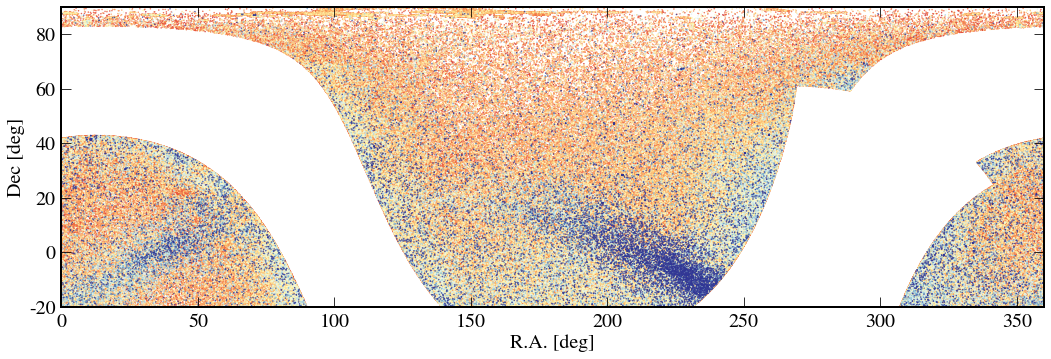

In [12]:
plt.figure(figsize=(15,7))
# plt.plot(f['RA'][ind][::10], f['DEC'][ind][::10], 'k.', ms=1, rasterized=True)
nskip = 1
ind_sort = np.argsort(f['brutus_mist_dist'][ind][::nskip])
plt.scatter(f['RA'][ind][::nskip][ind_sort], f['DEC'][ind][::nskip][ind_sort],
            c=f['brutus_mist_dist'][ind][::nskip][ind_sort], cmap='RdYlBu',
            vmin=0, vmax=40, rasterized=True, s=0.2)

plt.xlim(0,360)
plt.ylim(-20,90)
plt.gca().set_aspect('equal')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_distance.png', dpi=200)

## subtract solar reflex motion

In [10]:
c = coord.SkyCoord(ra=f['gaia.ra'][ind]*u.deg, dec=f['gaia.dec'][ind]*u.deg,
                   pm_ra_cosdec=f['gaia.pmra'][ind]*u.mas/u.yr, pm_dec=f['gaia.pmdec'][ind]*u.mas/u.yr,
                   radial_velocity=0*f['brutus_mist_dist'][ind]*u.km/u.s, distance=f['brutus_mist_dist'][ind]*u.kpc)
cg = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=cg.phi1, phi2=cg.phi2,
                    distance=cg.distance,
                    pm_phi1_cosphi2=cg.pm_phi1_cosphi2,
                    pm_phi2=cg.pm_phi2,
                    radial_velocity=cg.radial_velocity)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
# gd1_c_nosunv = coord.Galactic(rep).transform_to(gc.GD1)
cg = coord.Galactic(rep).transform_to(gc.GD1)

In [11]:
ce = cg.transform_to(coord.ICRS)

In [12]:
pm = np.sqrt(ce.pm_ra_cosdec.to(u.mas/u.yr)**2 + ce.pm_dec.to(u.mas/u.yr)**2)
theta_ra = ce.pm_ra_cosdec.to(u.mas/u.yr) / pm
theta_dec = ce.pm_dec.to(u.mas/u.yr) / pm

In [13]:
theta_ra

<Quantity [-0.34596599, -0.80476779,  0.88535388, ...,  0.89531143,
            0.62277972, -0.38155489]>

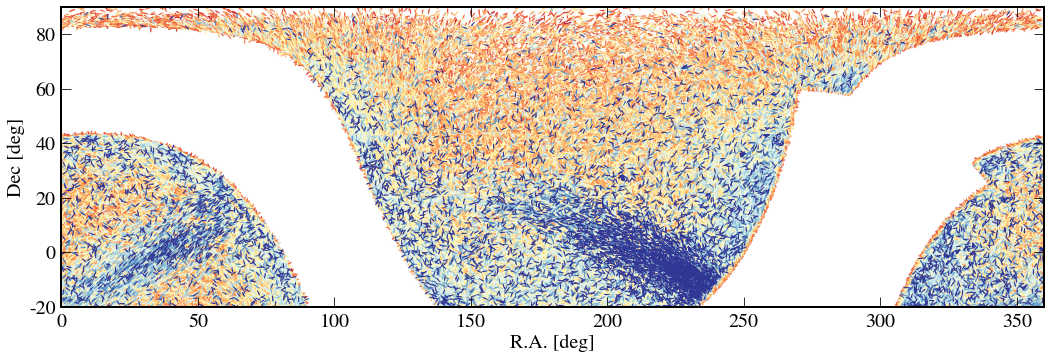

In [24]:
plt.figure(figsize=(15,7))
nskip = 2
ind_sort = np.argsort(ce.distance[::nskip])
parrows = plt.quiver(ce.ra[::nskip][ind_sort].value, ce.dec[::nskip][ind_sort].value,
           theta_ra[::nskip][ind_sort], theta_dec[::nskip][ind_sort],
           ce.distance[::nskip][ind_sort].value, cmap='RdYlBu',
          rasterized=True, headwidth=1.5, headlength=2, width=0.001, scale_units='inches', scale=12)
parrows.set_clim(vmin=0, vmax=40)

plt.xlim(0,360)
plt.ylim(-20,90)
plt.gca().set_aspect('equal')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_{:04d}.png'.format(nskip), dpi=200)

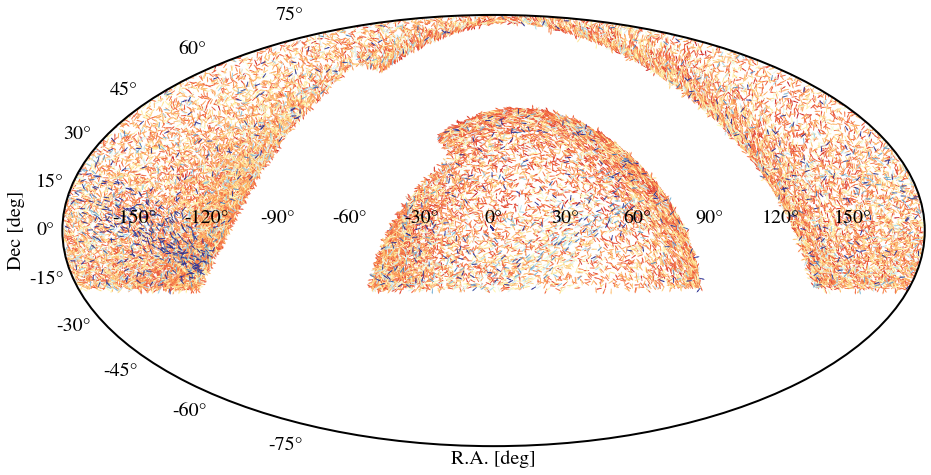

In [42]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

nskip = 20
ind_sort = np.argsort(ce.distance[::nskip])
parrows = plt.quiver(ce.ra[::nskip][ind_sort].wrap_at(wangle).to(u.rad).value,
                     ce.dec[::nskip][ind_sort].to(u.rad).value,
           theta_ra[::nskip][ind_sort], theta_dec[::nskip][ind_sort],
           ce.distance[::nskip][ind_sort].value, cmap='RdYlBu',
          rasterized=True, headwidth=1.5, headlength=2, width=0.001, scale_units='inches', scale=12)
parrows.set_clim(vmin=0, vmax=40)

# plt.xlim(0,360)
# plt.ylim(-20,90)
# plt.gca().set_aspect('equal')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_sky_{:04d}.png'.format(nskip), dpi=200)

In [14]:
cgal = cg.transform_to(coord.Galactic)

In [15]:
pmg = np.sqrt(cgal.pm_l_cosb.to(u.mas/u.yr)**2 + cgal.pm_b.to(u.mas/u.yr)**2)
theta_l = cgal.pm_l_cosb.to(u.mas/u.yr) / pmg
theta_b = cgal.pm_b.to(u.mas/u.yr) / pmg

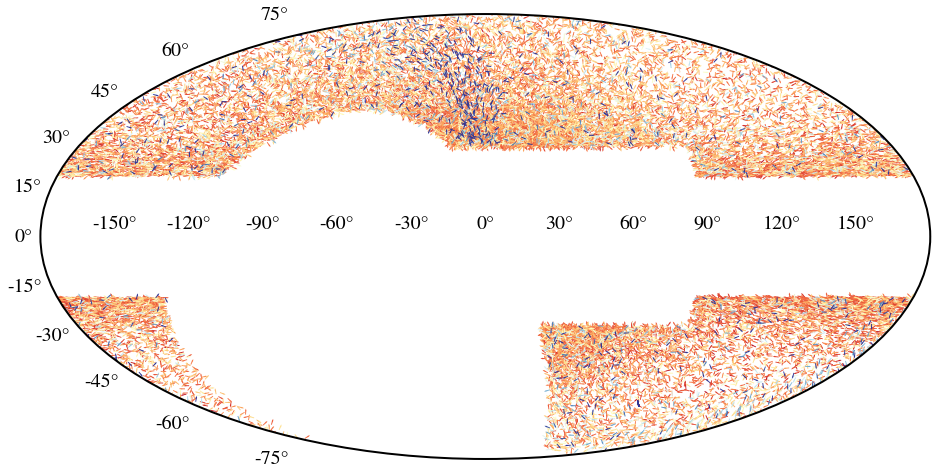

In [34]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

wangle = 180*u.deg
l0 = 0*u.deg
nskip = 20

ind_sort = np.argsort(cgal.distance[::nskip])
parrows = plt.quiver((cgal.l[::nskip][ind_sort]-l0).wrap_at(wangle).to(u.rad).value,
                     cgal.b[::nskip][ind_sort].to(u.rad).value,
           theta_l[::nskip][ind_sort], theta_b[::nskip][ind_sort],
           cgal.distance[::nskip][ind_sort].value, cmap='RdYlBu',
          rasterized=True, headwidth=1.5, headlength=2, width=0.001, scale_units='inches', scale=12)
parrows.set_clim(vmin=0, vmax=40)

# plt.xlim(0,360)
# plt.ylim(-20,90)
# plt.gca().set_aspect('equal')

# plt.xlabel('R.A. [deg]')
# plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_gal_{:04d}.png'.format(nskip), dpi=200)

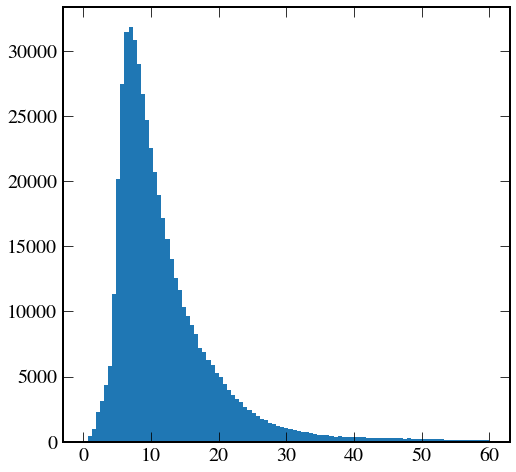

In [16]:
plt.hist(cg.distance.value, bins=np.linspace(0,60,100));

In [29]:
highb = (np.abs(cgal.b)>30*u.deg)

In [36]:
far = (cg.distance>30*u.kpc) & highb

In [37]:
np.sum(far), np.sum(highb)

(18473, 393588)

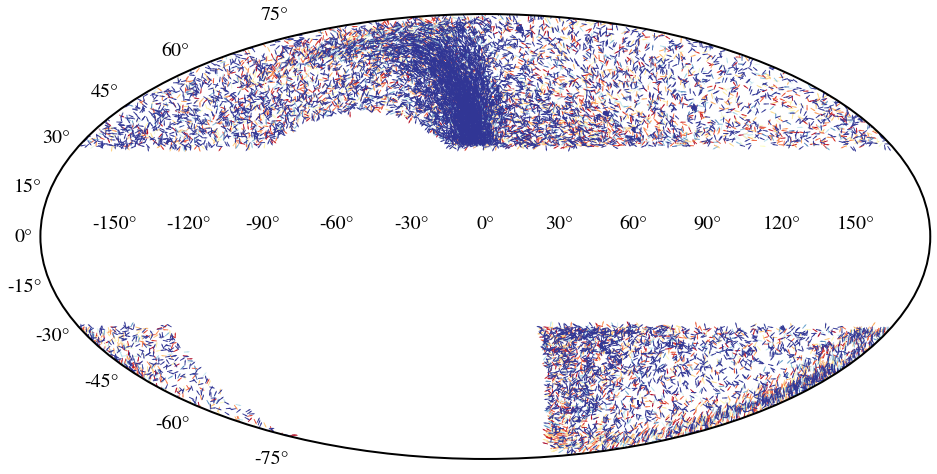

In [38]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

wangle = 180*u.deg
l0 = 0*u.deg
nskip = 1

ind_sort = np.argsort(cgal.distance[far][::nskip])
parrows = plt.quiver((cgal.l[far][::nskip][ind_sort]-l0).wrap_at(wangle).to(u.rad).value,
                     cgal.b[far][::nskip][ind_sort].to(u.rad).value,
           theta_l[far][::nskip][ind_sort], theta_b[far][::nskip][ind_sort],
           cgal.distance[far][::nskip][ind_sort].value, cmap='RdYlBu',
          rasterized=True, headwidth=1.5, headlength=2, width=0.001, scale_units='inches', scale=12)
parrows.set_clim(vmin=30, vmax=40)

# plt.xlim(0,360)
# plt.ylim(-20,90)
# plt.gca().set_aspect('equal')

# plt.xlabel('R.A. [deg]')
# plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_gal_far_{:04d}.png'.format(nskip), dpi=200)

## Cut on bestfit $\chi^2$

In [77]:
best = np.array(f['brutus_mist_bestchi2'][ind])/np.array(f['brutus_mist_nbands'][ind])<0.2

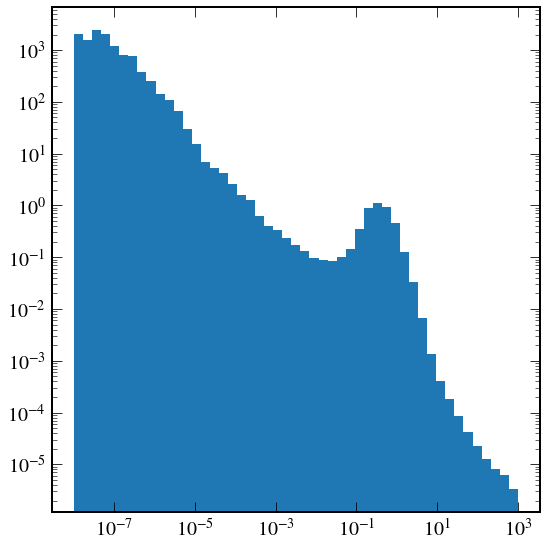

In [59]:
plt.hist(f['brutus_mist_bestchi2'][ind]/f['brutus_mist_nbands'][ind], bins=np.logspace(-8,3,50), density=True)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.tight_layout()

In [88]:
np.sum(best), np.sum(best & (cg.distance>10*u.kpc))

(34174, 8152)

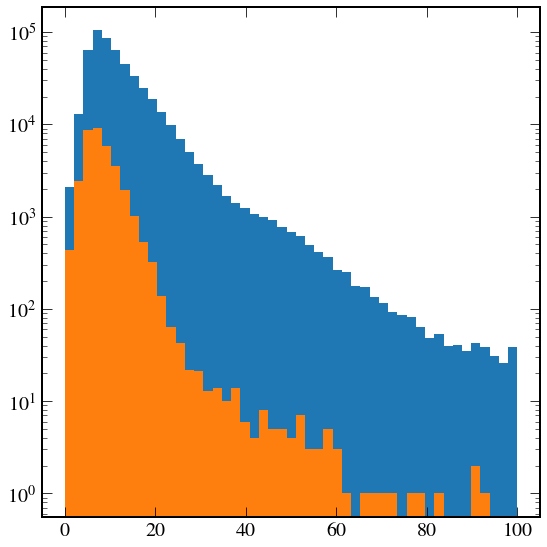

In [86]:
plt.hist(cg.distance.value, bins=np.linspace(0,100,50));
plt.hist(cg.distance[best].value, bins=np.linspace(0,100,50));

plt.gca().set_yscale('log')
plt.tight_layout()

## Average velocity field

In [151]:
import healpy as hp
import scipy.stats

In [152]:
def gen_fast_map(ip_, nside=512):
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
    return map_

def gen_binned_map(x, values, nside=512, statistic='mean'):
    npixel  = hp.nside2npix(nside)
    map_, be, bn = scipy.stats.binned_statistic(x, values, statistic=statistic, bins=np.arange(0,npixel+1,1))
    return map_

In [289]:
nside = 128
hp.nside2resol(nside, arcmin=True)

27.483891294539248

In [290]:
pix_id = hp.ang2pix(nside, ce.ra.deg, ce.dec.deg, lonlat=True)
pix_count = gen_fast_map(pix_id, nside=nside)

In [291]:
np.shape(pix_count), np.sum(pix_count>0), np.size(ind), np.sum(ind)

((196608,), 80690, 28320232, 515074)

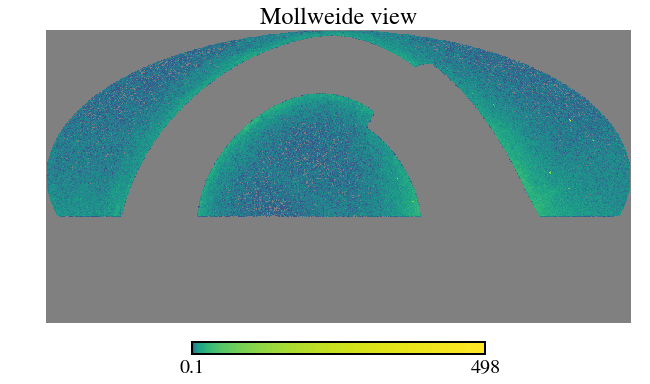

In [292]:
hp.visufunc.mollview(pix_count, norm=mpl.colors.LogNorm(), min=0.1)

In [293]:
pix_dist = gen_binned_map(pix_id, ce.distance.to(u.kpc).value, nside=nside)

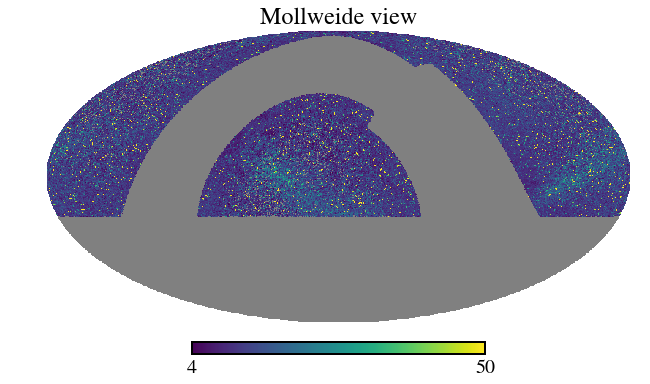

In [294]:
hp.visufunc.mollview(pix_dist, min=4, max=50)

In [295]:
pix_ra = gen_binned_map(pix_id, ce.ra.to(u.deg).value, nside=nside)
pix_dec = gen_binned_map(pix_id, ce.dec.to(u.deg).value, nside=nside)
pix_pmra = gen_binned_map(pix_id, ce.pm_ra_cosdec.to(u.mas/u.yr).value, nside=nside)
pix_pmdec = gen_binned_map(pix_id, ce.pm_dec.to(u.mas/u.yr).value, nside=nside)

In [296]:
pix_pm = np.sqrt(pix_pmra**2 + pix_pmdec**2)
pix_theta_ra = pix_pmra / pix_pm
pix_theta_dec = pix_pmdec / pix_pm

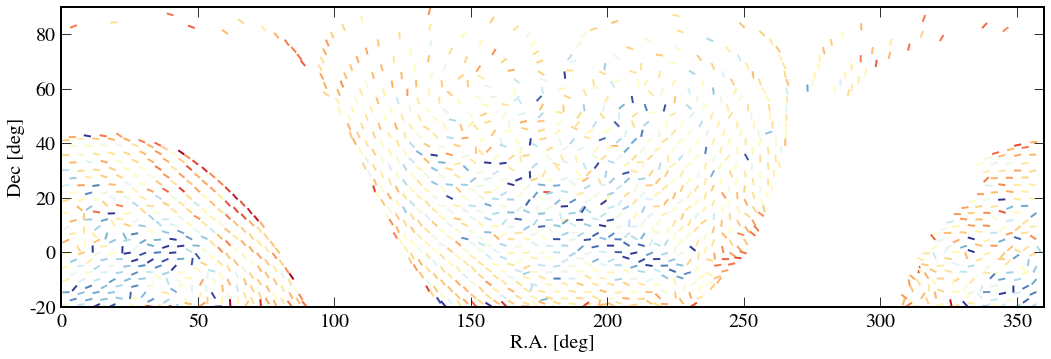

In [287]:
fig = plt.figure(figsize=(15,7))
# ax = fig.add_subplot(111, projection='mollweide')

nskip = 20
# ind_sort = np.argsort(ce.distance[::nskip])
# parrows = plt.quiver(ce.ra[::nskip][ind_sort].wrap_at(wangle).to(u.rad).value,
#                      ce.dec[::nskip][ind_sort].to(u.rad).value,
#            theta_ra[::nskip][ind_sort], theta_dec[::nskip][ind_sort],
#            ce.distance[::nskip][ind_sort].value, cmap='RdYlBu',
#           rasterized=True, headwidth=1.5, headlength=2, width=0.001, scale_units='inches', scale=12)

parrows = plt.quiver(pix_ra, pix_dec, pix_theta_ra, pix_theta_dec, pix_dist, cmap='RdYlBu',
          rasterized=True, headwidth=1, headlength=0, width=0.002, scale_units='inches', scale=10)
parrows.set_clim(vmin=8, vmax=20)

plt.xlim(0,360)
plt.ylim(-20,90)
plt.gca().set_aspect('equal')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_pix_{:03d}.png'.format(nside), dpi=200)

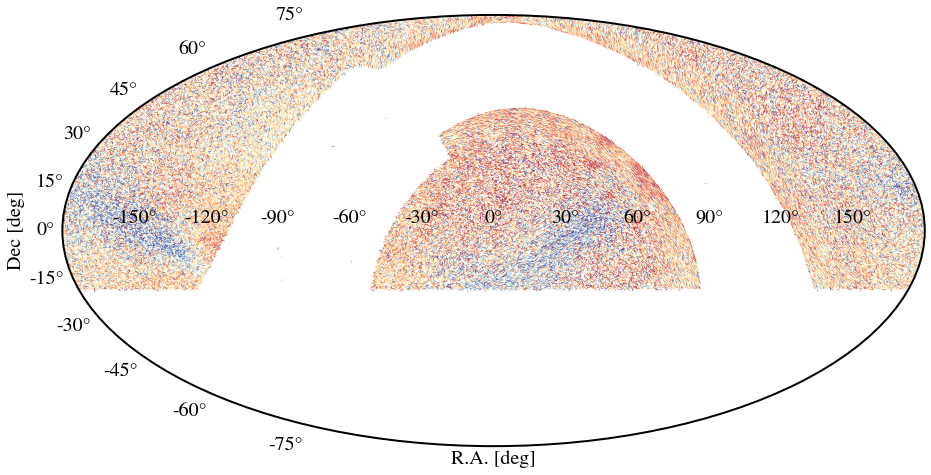

In [297]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_dist, cmap='RdYlBu',
          rasterized=True, headwidth=1, headlength=0, width=0.0005, scale_units='inches', scale=25)
parrows.set_clim(vmin=6, vmax=20)

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_pixsky_{:03d}.png'.format(nside), dpi=200)

### Nearby stars (d < 30 kpc)

In [298]:
close = ce.distance<30*u.kpc

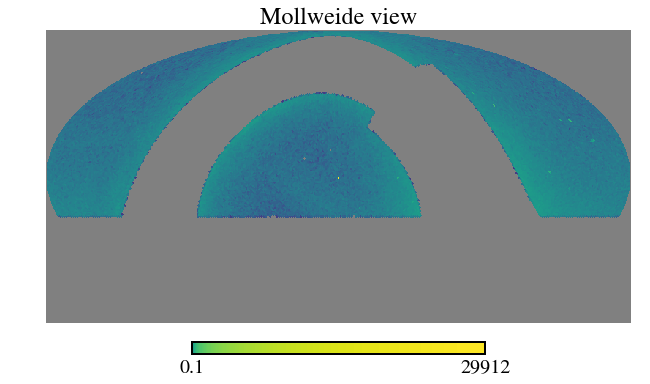

In [317]:
nside = 64
pix_id = hp.ang2pix(nside, ce[close].ra.deg, ce[close].dec.deg, lonlat=True)
pix_count = gen_fast_map(pix_id, nside=nside)
hp.visufunc.mollview(pix_count, norm=mpl.colors.LogNorm(), min=0.1)

In [318]:
pix_ra = gen_binned_map(pix_id, ce[close].ra.to(u.deg).value, nside=nside)
pix_dec = gen_binned_map(pix_id, ce[close].dec.to(u.deg).value, nside=nside)
pix_pmra = gen_binned_map(pix_id, ce[close].pm_ra_cosdec.to(u.mas/u.yr).value, nside=nside)
pix_pmdec = gen_binned_map(pix_id, ce[close].pm_dec.to(u.mas/u.yr).value, nside=nside)
pix_dist = gen_binned_map(pix_id, ce[close].distance.to(u.kpc).value, nside=nside)

pix_pm = np.sqrt(pix_pmra**2 + pix_pmdec**2)
pix_theta_ra = pix_pmra / pix_pm
pix_theta_dec = pix_pmdec / pix_pm

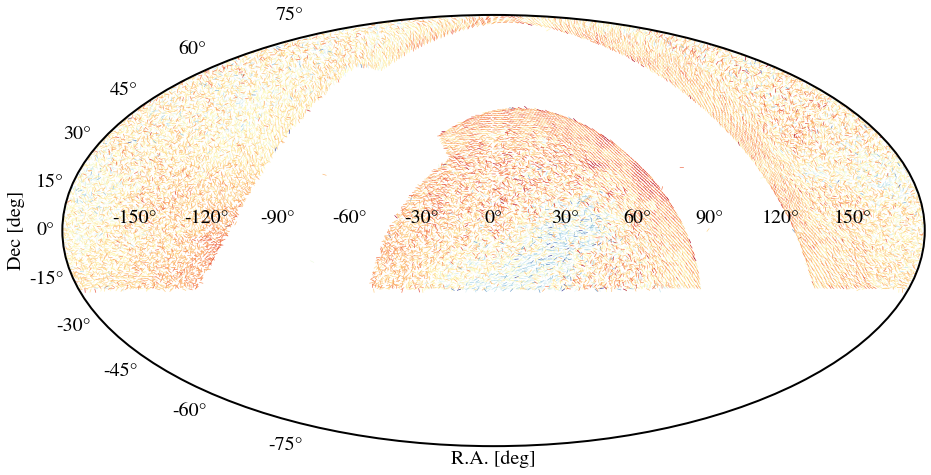

In [319]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_dist, cmap='RdYlBu',
          rasterized=True, headwidth=1, headlength=0, width=0.0005*(128/nside)**0.5, scale_units='inches',
                     scale=25*(nside/128)**0.5)
parrows.set_clim(vmin=6, vmax=20)

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_close_pixsky_{:03d}.png'.format(nside), dpi=200)

### Distant stars (d > 30 kpc)

In [386]:
cgal = ce.transform_to(coord.Galactocentric)

In [400]:
far = (ce.distance>30*u.kpc) #& (np.abs(cgal.z)>10*u.kpc)

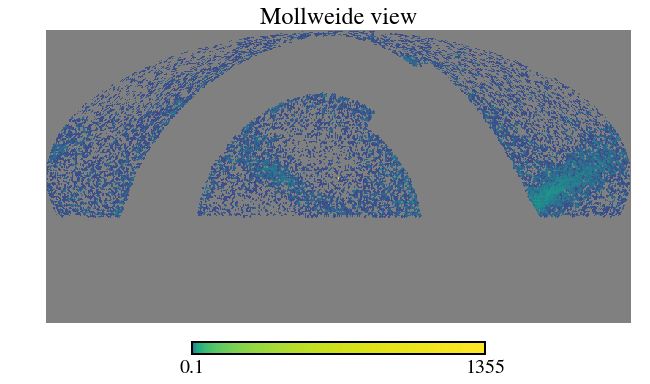

In [401]:
nside = 64
pix_id = hp.ang2pix(nside, ce[far].ra.deg, ce[far].dec.deg, lonlat=True)
pix_count = gen_fast_map(pix_id, nside=nside)
hp.visufunc.mollview(pix_count, norm=mpl.colors.LogNorm(), min=0.1)

In [402]:
pix_ra = gen_binned_map(pix_id, ce[far].ra.to(u.deg).value, nside=nside)
pix_dec = gen_binned_map(pix_id, ce[far].dec.to(u.deg).value, nside=nside)
pix_pmra = gen_binned_map(pix_id, ce[far].pm_ra_cosdec.to(u.mas/u.yr).value, nside=nside)
pix_pmdec = gen_binned_map(pix_id, ce[far].pm_dec.to(u.mas/u.yr).value, nside=nside)
pix_dist = gen_binned_map(pix_id, ce[far].distance.to(u.kpc).value, nside=nside)

pix_pm = np.sqrt(pix_pmra**2 + pix_pmdec**2)
pix_theta_ra = pix_pmra / pix_pm
pix_theta_dec = pix_pmdec / pix_pm

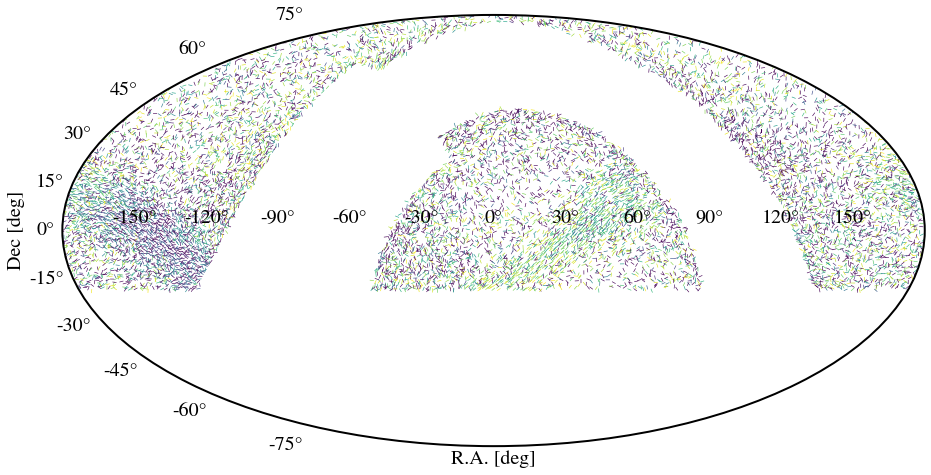

In [405]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_dist, cmap='viridis_r',
          rasterized=True, headwidth=1, headlength=0, width=0.0005*(128/nside)**0.5, scale_units='inches',
                     scale=25*(nside/128)**0.5)
parrows.set_clim(vmin=30, vmax=50)

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('../plots/halo_pm_30plus_pixsky_{:03d}.png'.format(nside), dpi=200)

### Color by velocity dispersion

In [433]:
far = (ce.distance>20*u.kpc)

In [469]:
nside = 256
pix_id = hp.ang2pix(nside, ce[far].ra.deg, ce[far].dec.deg, lonlat=True)
pix_count = gen_fast_map(pix_id, nside=nside)

pix_ra = gen_binned_map(pix_id, ce[far].ra.to(u.deg).value, nside=nside)
pix_dec = gen_binned_map(pix_id, ce[far].dec.to(u.deg).value, nside=nside)
pix_pmra = gen_binned_map(pix_id, ce[far].pm_ra_cosdec.to(u.mas/u.yr).value, nside=nside)
pix_pmdec = gen_binned_map(pix_id, ce[far].pm_dec.to(u.mas/u.yr).value, nside=nside)
pix_dist = gen_binned_map(pix_id, ce[far].distance.to(u.kpc).value, nside=nside)

pix_pm = np.sqrt(pix_pmra**2 + pix_pmdec**2)
pix_theta_ra = pix_pmra / pix_pm
pix_theta_dec = pix_pmdec / pix_pm

theta = np.arctan(ce[far].pm_dec.to(u.mas/u.yr).value,ce[far].pm_ra_cosdec.to(u.mas/u.yr).value)
pix_theta_std = gen_binned_map(pix_id, theta, nside=nside, statistic='std')

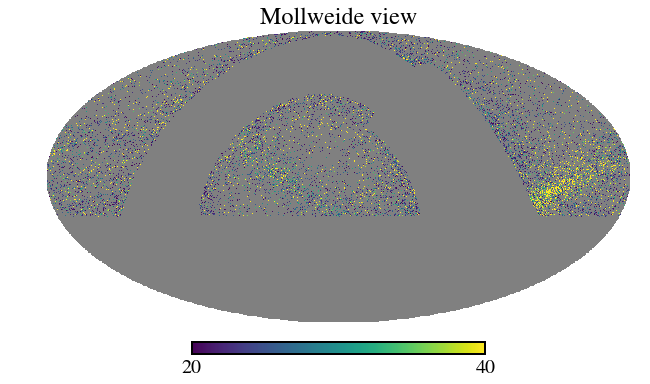

In [470]:
hp.visufunc.mollview(pix_dist, max=40)

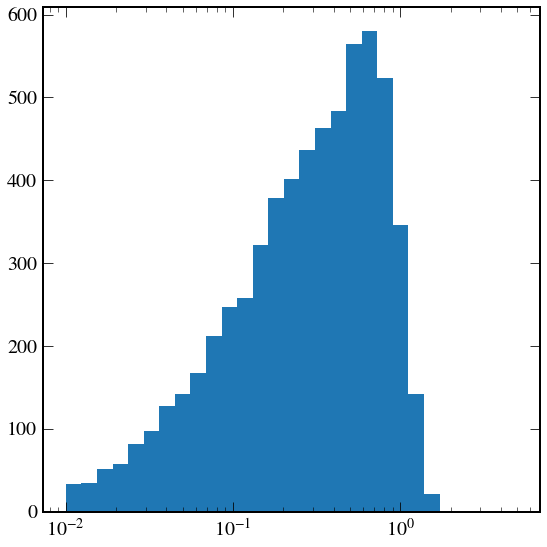

In [471]:
plt.hist(pix_theta_std, bins=np.logspace(-2,0.7,30))
plt.gca().set_xscale('log')
plt.tight_layout()

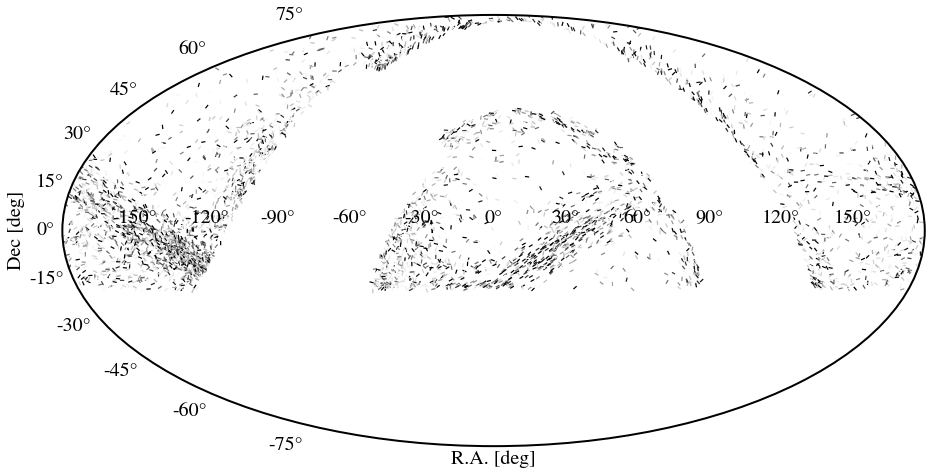

In [472]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

# parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
#                      pix_theta_ra, pix_theta_dec, pix_theta_std, cmap='Greys_r', norm=mpl.colors.LogNorm(),
#           rasterized=True, headwidth=1, headlength=0, width=0.0005*(128/nside)**0.5, scale_units='inches',
#                      scale=25*(nside/128)**0.5)
parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_theta_std, cmap='Greys_r', norm=mpl.colors.LogNorm(),
          rasterized=True, headwidth=1, headlength=0, width=0.002*(128/nside)**0.5, scale_units='inches',
                     scale=12*(nside/128)**0.5)
parrows.set_clim(vmin=0.05, vmax=0.5)

# plt.gca().invert_xaxis()
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.tight_layout()
plt.savefig('../plots/halo_pm_std_pixsky_{:03d}.png'.format(nside), dpi=200)